## BBC News Reviews Classification Model - Sentiment Analysis

Build a classification model using the **BBC News dataset** that is able to predict on a hold-out set the sentiment of the reviews with at minimum 92% accuracy. You can pick ONE of the topics to be your positive class, and label everything else to be negative. Ensure class imbalance is handled.

Git Cloning

In [1]:
!rm -rf dso-560-nlp-text-analytics && git clone https://github.com/ychennay/dso-560-nlp-text-analytics

Cloning into 'dso-560-nlp-text-analytics'...
remote: Enumerating objects: 3206, done.
remote: Total 3206 (delta 0), reused 0 (delta 0), pack-reused 3206
Receiving objects: 100% (3206/3206), 95.46 MiB | 14.72 MiB/s, done.
Resolving deltas: 100% (411/411), done.
Checking out files: 100% (3186/3186), done.


In [2]:
%cd dso-560-nlp-text-analytics

/content/dso-560-nlp-text-analytics


Importing Packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple
import spacy
import re
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Loading Corpus (BBC News data)

In [4]:
def load_bbc_corpus(directory: str, topics: List[str], num_docs: int)-> pd.DataFrame:
  articles: List[Tuple[str, str]] = [(f"datasets/{directory}/{topic}/{str(i).zfill(3)}.txt", topic) for i in range(1,num_docs + 1) for topic in TOPICS]

  data = []
  for article, topic in articles:
      with open(article, encoding="latin1") as article: # open each sports article
        content = article.read()
        data.append({"topic": topic, "text": content})

  # generate a dataframe
  df = pd.DataFrame(data)
  df.text = df.text.apply(lambda text: text.replace("\n", " "))
  return df

In [5]:
documents = []
TOPICS = ["business", "sport", "entertainment", "tech", "politics"]
news_df = load_bbc_corpus("bbc", TOPICS, num_docs=350)
news_df.head()

,topic,text
0,business,Ad sales boost Time Warner profit Quarterly p...
1,sport,Claxton hunting first major medal British hur...
2,entertainment,Gallery unveils interactive tree A Christmas ...
3,tech,Ink helps drive democracy in Asia The Kyrgyz ...
4,politics,Labour plans maternity pay rise Maternity pay...


In [6]:
print(f" Shape of dataset: {news_df.shape}")

 Shape of dataset: (1750, 2)


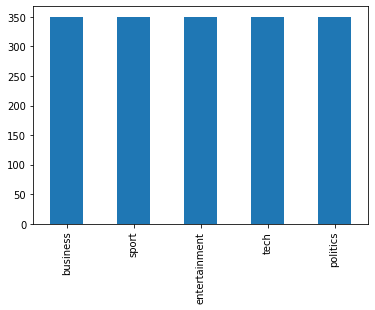

In [7]:
news_df.topic.value_counts().plot(kind = 'bar')

Label Assignment

In [8]:
news_df['class'] = news_df['topic'].apply(lambda x: 1 if x == "tech" else 0)
news_df.head()

,topic,text,class
0,business,Ad sales boost Time Warner profit Quarterly p...,0
1,sport,Claxton hunting first major medal British hur...,0
2,entertainment,Gallery unveils interactive tree A Christmas ...,0
3,tech,Ink helps drive democracy in Asia The Kyrgyz ...,1
4,politics,Labour plans maternity pay rise Maternity pay...,0


In [9]:
news_df['class'].value_counts()

0    1400
1     350
Name: class, dtype: int64

Sampling Dataframes

In [10]:
def pick_samples(topic1, topic2, topic3, topic4):
  for i in range(4):
    name = 'topic'+str(i)
    df_temp = pd.DataFrame()
    df_temp = news_df[news_df['topic'] == str(name)].sample(n=87, replace = False)
    df_samp = df_samp.append(df_temp)
    return df_samp

In [11]:
# sampled_df = pick_samples("business", "sport", "entertainment", "politics")

In [12]:
biz_df = news_df[news_df['topic'] == 'business'].sample(n=87, replace = False, random_state = 101)
sport_df = news_df[news_df['topic'] == 'sport'].sample(n=87, replace = False, random_state = 101)
ent_df = news_df[news_df['topic'] == 'entertainment'].sample(n=87, replace = False, random_state = 101)
polit_df = news_df[news_df['topic'] == 'politics'].sample(n=87, replace = False, random_state = 101)

class_0_df = biz_df.append([sport_df, ent_df, polit_df])
print(class_0_df.head())
print(class_0_df.shape)

         topic                                               text  class
770   business  Macy's owner buys rival for $11bn  US retail g...      0
1395  business  Amex shares up on spin-off news  Shares in Ame...      0
430   business  Worldcom boss 'left books alone'  Former World...      0
190   business  Chinese wine tempts Italy's Illva  Italy's Ill...      0
240   business  BMW cash to fuel Mini production  Less than fo...      0
(348, 3)


In [13]:
class_1_df = news_df[news_df['class'] == 1]
drop_indices = np.random.choice(class_1_df.index, 2, replace = False)
class_1_df.drop(drop_indices, inplace = True)
print(class_1_df.head())
print(class_1_df.shape)

   topic                                               text  class
3   tech  Ink helps drive democracy in Asia  The Kyrgyz ...      1
8   tech  China net cafe culture crackdown  Chinese auth...      1
13  tech  Microsoft seeking spyware trojan  Microsoft is...      1
18  tech  Digital guru floats sub-$100 PC  Nicholas Negr...      1
23  tech  Technology gets the creative bug  The hi-tech ...      1
(348, 3)


In [14]:
news_df_final = class_1_df.append(class_0_df)
#news_df_final.sample(frac = 1)
news_df_final.shape

(696, 3)

Creating Docs

In [15]:
class0_text = [i for i in news_df_final[news_df_final['class']==0].text]
class1_text = [i for i in news_df_final[news_df_final['class']==1].text]
docs = class0_text + class1_text

Creating Labels

In [16]:
labels = np.concatenate([np.zeros(348), np.ones(348)])

Removing Stopwords

In [17]:
nlp = spacy.load('en_core_web_sm', disable=["ner", "pos", "tagger"])
stopwords_cleaned_docs = list(
    map(lambda doc: " ".join([token.text for token in nlp(doc) if not token.is_stop]), docs))

In [18]:
stopwords_cleaned_docs[2]

'Worldcom boss \' left books \'   Worldcom boss Bernie Ebbers , accused overseeing $ 11bn ( Â£5.8bn ) fraud , accounting decisions , witness told jurors .   David Myers comments questioning defence lawyers arguing Mr Ebbers responsible Worldcom problems . phone company collapsed 2002 prosecutors claim losses hidden protect firm shares . Mr Myers pleaded guilty fraud assisting prosecutors .   Monday , defence lawyer Reid Weingarten tried distance client allegations . cross examination , asked Mr Myers knew Mr Ebbers " accounting decision ? " . " aware , " Mr Myers replied . " know Mr Ebbers accounting entry Worldcom books ? " Mr Weingarten pressed . " , " replied witness . Mr Myers admitted ordered false accounting entries request Worldcom chief financial officer Scott Sullivan . Defence lawyers trying paint Mr Sullivan , admitted fraud testify later trial , mastermind Worldcom accounting house cards .   Mr Ebbers \' team , , looking portray affable boss , admission PE graduate economis

Data Cleaning

In [19]:
def clean(review_text):
    review_text = str(review_text).lower() # convert to lowercase
    #review_text = re.sub('\[.*?\]', '', review_text)
    review_text = re.sub('https?://\S+|www\.\S+', '', review_text) # Remove URls
    review_text = re.sub('<.*?>+', '', review_text)
    review_text = re.sub(r'[^a-z0-9\s]', '', review_text) # Remove punctuation
    review_text = re.sub('\n', '', review_text)
    review_text = re.sub('\w*\d\w*', '', review_text)

    review_text = re.sub('\s+',' ', review_text) #replace_multiple_spaces_with_single_space
    return(review_text)

Tokenizing

In [20]:
tokenizer = Tokenizer(num_words=5555, oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(stopwords_cleaned_docs)

In [21]:
vocab_size = int(len(tokenizer.word_index) * 1.3)
print(f"Vocab size is {vocab_size} unique tokens.")

Vocab size is 22449 unique tokens.


Integer Encoding the Documents

In [22]:
def integer_encode_documents(docs, tokenizer):
    return tokenizer.texts_to_sequences(docs)

In [23]:
# integer encode the documents
encoded_docs = integer_encode_documents(stopwords_cleaned_docs, tokenizer)

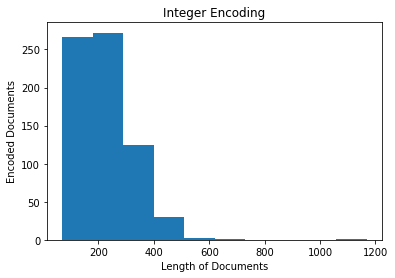

In [24]:
plt.hist(list(map(lambda doc: len(doc), encoded_docs)))
plt.xlabel('Length of Documents')
plt.ylabel('Encoded Documents')
plt.title('Integer Encoding')
plt.show()

Finding Maximum Length of Documents

In [25]:
def get_max_token_length_per_doc(docs: List[str])-> int:
    return max(list(map(lambda x: len(x.split()), docs)))

In [26]:
def get_max_token_length_per_doc(docs: List[str], tokenizer)-> int:
  return max(list(map(lambda doc: len(doc), tokenizer.texts_to_sequences(docs))))

In [27]:
# get the max length in terms of token length
max_length1 = get_max_token_length_per_doc(docs, tokenizer)
max_length1

2446

In [28]:
# get the max length in terms of token length
max_length2 = get_max_token_length_per_doc(stopwords_cleaned_docs, tokenizer)
max_length2

1169

Pad Documents to Maximum Length 

In [29]:
padded_docs = pad_sequences(encoded_docs, maxlen = max_length2, padding='post')
padded_docs[2]

array([2048,  596,    7, ...,    0,    0,    0], dtype=int32)

Defining an Embedded size

In [30]:
EMBEDDING_SIZE = 120

Train Test Split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(padded_docs,
                                                    labels, 
                                                    test_size=0.3,
                                                    stratify=labels)

Defining and Compiling the model

In [32]:
# define the model
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE, input_length=max_length2))
model.add(Flatten()) 

model.add(Dense(1, activation='sigmoid')) 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1169, 120)         2693880   
                                                                 
 flatten (Flatten)           (None, 140280)            0         
                                                                 
 dense (Dense)               (None, 1)                 140281    
                                                                 
Total params: 2,834,161
Trainable params: 2,834,161
Non-trainable params: 0
_________________________________________________________________


Fitting the model

In [33]:
# fit the model
model.fit(X_train, y_train, epochs=25, verbose=1)
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

Epoch 1/25
16/16 [==============================] - 2s 54ms/step - loss: 0.7726 - acc: 0.5462
Epoch 2/25
16/16 [==============================] - 1s 51ms/step - loss: 0.5053 - acc: 0.7515
Epoch 3/25
16/16 [==============================] - 1s 52ms/step - loss: 0.2464 - acc: 0.9733
Epoch 4/25
16/16 [==============================] - 1s 51ms/step - loss: 0.1031 - acc: 0.9897
Epoch 5/25
16/16 [==============================] - 1s 66ms/step - loss: 0.0395 - acc: 1.0000
Epoch 6/25
16/16 [==============================] - 1s 64ms/step - loss: 0.0192 - acc: 1.0000
Epoch 7/25
16/16 [==============================] - 1s 50ms/step - loss: 0.0119 - acc: 1.0000
Epoch 8/25
16/16 [==============================] - 1s 53ms/step - loss: 0.0082 - acc: 1.0000
Epoch 9/25
16/16 [==============================] - 1s 53ms/step - loss: 0.0063 - acc: 1.0000
Epoch 10/25
16/16 [==============================] - 1s 50ms/step - loss: 0.0050 - acc: 1.0000
Epoch 11/25
16/16 [==============================] - 1s 50m

Evalauting the model

In [34]:
# Predicting on test data
y_pred = np.where(model.predict(X_test)[:]>=0.5,1,0)
# Evaluate the model
score = accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score,2)*100}%')

Accuracy: 98.0%


Confusion Matrix

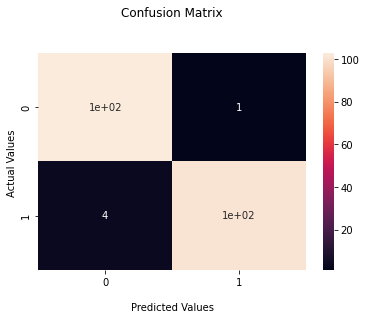

In [35]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_matrix, annot=True)

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Topic Modelling

Perform topic modelling on the `news_categories.csv` dataset. This dataset is from [News Category Dataset, Akash Gupta](https://www.kaggle.com/datasets/akash14/news-category-dataset)

In [36]:
news=pd.read_csv('datasets/news_categories.csv',encoding='latin1')

In [37]:
news.head()

,STORY,SECTION
0,But the most painful was the huge reversal in ...,3
1,How formidable is the opposition alliance amon...,0
2,Most Asian currencies were trading lower today...,3
3,"If you want to answer any question, click on ...",1
4,"In global markets, gold prices edged up today ...",3


In [38]:
from gensim.parsing.preprocessing import STOPWORDS
from gensim.parsing.preprocessing import remove_stopwords
custom_stopwords=set(STOPWORDS)
to_add = ["Im", 'its']
stops = ["not","doesn't","didn't","wouldn't","shouldn't","couldn't"]
custom_stopwords = list(custom_stopwords - set(stops) | set(to_add))


In [39]:
## lemmatization
## https://gist.github.com/gaurav5430/9fce93759eb2f6b1697883c3782f30de#file-nltk-lemmatize-sentences-py
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)


In [40]:
news2=news.reset_index()

In [41]:
import re
#remove punctuations

news2["cleaned_stories_punc"]=news2["STORY"].apply(lambda x: str(' '.join(re.findall(r'\w+',str(nltk.word_tokenize(x))))))    



#remove stopwords
cleaned_stories_list=[]
for story in news2["cleaned_stories_punc"]:
    #print(review)
    words = nltk.word_tokenize(story)
    #print(words)
    new_words = []
    for word in words:
        if word.lower() in custom_stopwords:
            continue
        else:
          new_words.append(word.lower())
        cleaned_story = " ".join(new_words)
    cleaned_stories_list.append(cleaned_story)

cleaned_stories= pd.Series(cleaned_stories_list)  

news2["cleaned_stories_punc_stop"]=cleaned_stories


#lemmatize

news2["cleaned_stories_lemm"]=news2["cleaned_stories_punc_stop"].apply(lambda x: lemmatize_sentence(x))


In [42]:
trigram_vectorizer = TfidfVectorizer(ngram_range=(2,2),min_df=3,max_df=0.4)

In [43]:
news_tri, news_terms_tri  = trigram_vectorizer.fit_transform(news2.cleaned_stories_lemm.values.astype('U'))\
                                                                                 , trigram_vectorizer.get_feature_names_out()

In [44]:
X_news_tri_idf = pd.DataFrame(news_tri.toarray(), columns=news_terms_tri)

In [45]:
nmf = NMF(n_components=4)
W_news = nmf.fit_transform(X_news_tri_idf)
H_news = nmf.components_
print(f"Original shape of X kindle is {X_news_tri_idf.shape}")
print(f"Decomposed W kindle matrix is {W_news.shape}")
print(f"Decomposed H kindle matrix is {H_news.shape}")

Original shape of X kindle is (7628, 21956)
Decomposed W kindle matrix is (7628, 4)
Decomposed H kindle matrix is (4, 21956)


In [46]:
def get_top_tf_idf_tokens_for_topic(H: np.array, feature_names: List[str], num_top_tokens: int = 10):
  """
  Uses the H matrix (K components x M original features) to identify for each
  topic the most frequent tokens.
  """
  for topic, vector in enumerate(H):
    print(f"TOPIC {topic}\n")
    total = vector.sum()
    top_scores = vector.argsort()[::-1][:num_top_tokens]
    token_names = list(map(lambda idx: feature_names[idx], top_scores))
    strengths = list(map(lambda idx: vector[idx] / total, top_scores))
    
    for strength, token_name in zip(strengths, token_names):
      print(f"\b{token_name} ({round(strength * 100, 1)}%)\n")
    print(f"=" * 50)

print(f" News Categories:\n\n")
get_top_tf_idf_tokens_for_topic(H_news, X_news_tri_idf.columns.tolist(), 10)

 News Categories:


TOPIC 0

text headline (6.7%)

headline change (6.7%)

agency fee (6.7%)

wire agency (6.7%)

fee modification (6.7%)

publish wire (6.7%)

modification text (6.7%)

story publish (6.7%)

say story (0.5%)

add story (0.4%)

TOPIC 1

lok sabha (1.2%)

prime minister (0.7%)

narendra modi (0.6%)

sabha election (0.6%)

minister narendra (0.5%)

janata party (0.5%)

bharatiya janata (0.5%)

chief minister (0.5%)

party bjp (0.4%)

sabha seat (0.4%)

TOPIC 2

currency trade (3.6%)

x92s strength (3.1%)

measure currency (3.1%)

index measure (3.1%)

major currency (3.1%)

dollar index (3.0%)

currency x92s (3.0%)

previous close (3.0%)

strength major (2.8%)

close 96 (2.2%)

TOPIC 3

note pro (1.6%)

redmi note (1.6%)

internal storage (0.9%)

ram 64gb (0.6%)

64gb internal (0.6%)

6gb ram (0.6%)

4gb ram (0.4%)

qualcomm snapdragon (0.4%)

lcd display (0.4%)

camera setup (0.3%)



### The salient topics basis our topic modelling are:

1) Media & Entertainment

2) Politics

3) Business

4) Technology

This more or less falls in line with the categories mentioned in the source dataset.
